In [1]:
import cv2
import torch
import kornia
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils import warp_image
from utils import image_shape_to_corners
from utils import four_point_to_homography

# Prepare image

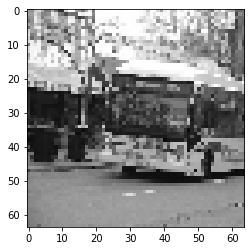

In [3]:
def load_image(filepath):
    image_bgr_np = cv2.imread(filepath)
    image_bgr_np = image_bgr_np[:, :428]
    image_bgr_np = cv2.resize(image_bgr_np, (64, 64))
    image_np = np.expand_dims(cv2.cvtColor(image_bgr_np, cv2.COLOR_BGR2GRAY), axis=-1)
    plt.imshow(np.tile(image_np, (1, 1, 3)))
    return image_np
image_np = load_image('COCO_val2014_000000000641.jpg')

# Prepare synthetic data gen

In [4]:
def prepare_train_sample(delta_np=None, visualize=False):
    if delta_np is None:
        delta_np = np.random.randint(-8, 8, 8).reshape(4, 2)
    corners_np = image_shape_to_corners(np.expand_dims(np.transpose(image_np, (2, 0, 1)), axis=0))
    homography_np = four_point_to_homography(corners_np, np.expand_dims(delta_np, axis=0))
    image_warped_np = warp_image(image_np, homography_np, target_h=image_np.shape[0], target_w=image_np.shape[1], inverse=False)
    image_warped_np = np.expand_dims(image_warped_np, axis=-1)
    if visualize:
        plt.imshow(np.tile(image_warped_np, (1, 1, 3)))
    return image_warped_np, corners_np[0], delta_np, homography_np

Original image shape: (64, 64, 1)
Warped image shape: (64, 64, 1)
Image corners shape: (4, 2)
Ground truth delta shape: (4, 2)
Ground truth homography shape: (3, 3)


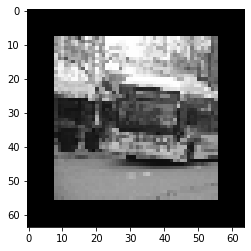

In [5]:
# Hand-defined warp
ret = prepare_train_sample(delta_np = np.array([[8, 8], [-8, 8], [-8, -8], [8, -8]]),
                           visualize=True)
print('Original image shape: {}'.format(image_np.shape))
print('Warped image shape: {}'.format(ret[0].shape))
print('Image corners shape: {}'.format(ret[1].shape))
print('Ground truth delta shape: {}'.format(ret[2].shape))
print('Ground truth homography shape: {}'.format(ret[3].shape))

Original image shape: (64, 64, 1)
Warped image shape: (64, 64, 1)
Image corners shape: (4, 2)
Ground truth delta shape: (4, 2)
Ground truth homography shape: (3, 3)


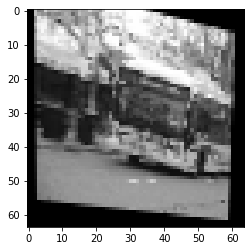

In [6]:
# Random warp
ret = prepare_train_sample(visualize=True)
print('Original image shape: {}'.format(image_np.shape))
print('Warped image shape: {}'.format(ret[0].shape))
print('Image corners shape: {}'.format(ret[1].shape))
print('Ground truth delta shape: {}'.format(ret[2].shape))
print('Ground truth homography shape: {}'.format(ret[3].shape))

# Target perspective field

In [7]:
def create_gt_perspective_field(h, w, homography, corners):
    
    # Create grid of targets
    y_grid, x_grid = np.mgrid[0:h, 0:w]
    point_grid = np.vstack((x_grid.flatten(), y_grid.flatten())).transpose()

    # Transform grid of points
    point_grid_t = cv2.perspectiveTransform(np.array([point_grid], dtype=np.float32), homography).squeeze()
    diff_grid_t = point_grid_t - point_grid
    diff_x_grid_t = diff_grid_t[:, 0]
    diff_y_grid_t = diff_grid_t[:, 1]
    diff_x_grid_t = diff_x_grid_t.reshape((h, w))
    diff_y_grid_t = diff_y_grid_t.reshape((h, w))

    pf_patch_x_branch = diff_x_grid_t[corners[0, 1]:corners[3, 1], corners[0, 0]:corners[1, 0]]
    pf_patch_y_branch = diff_y_grid_t[corners[0, 1]:corners[3, 1], corners[0, 0]:corners[1, 0]]

    # Create target
    target = np.zeros((h, w, 2))
    target[:, :, 0] = pf_patch_x_branch
    target[:, :, 1] = pf_patch_y_branch
    return target

def visualize_perspective_field(perspective_field, corners, image_1, homography, no_of_random_points=5):

    target = np.tile(image_1.astype(np.uint8), (1, 1, 3))
    random_points = np.random.choice(min(target.shape[0], target.shape[1]), no_of_random_points*2)
    for h, w in zip([0, 0, target.shape[0] - 1, target.shape[0] - 1, corners[0, 1]] + random_points[:no_of_random_points].tolist(),
                    [0, target.shape[1] - 1, 0, target.shape[1] - 1, corners[0, 0]] + random_points[no_of_random_points:].tolist()):
        x = perspective_field[h, w, 0].astype(int)
        y = perspective_field[h, w, 1].astype(int)
        cv2.arrowedLine(target, (w, h), (w + x, h + y), color=(255, 0, 0), thickness=1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    
    ax1.imshow(np.tile(image_1.astype(np.uint8), (1, 1, 3)))
    ax1.set_title('orig_image')

    image_2 = warp_image(image_1, homography, target_h=image_np.shape[0], target_w=image_np.shape[1], inverse=False)
    image_2 = np.expand_dims(image_2, axis=-1)
    ax2.imshow(np.tile(image_2.astype(np.uint8), (1, 1, 3)))
    ax2.set_title('warped_image')
    
    ax3.imshow(target)
    ax3.set_title('pf')
    plt.show()

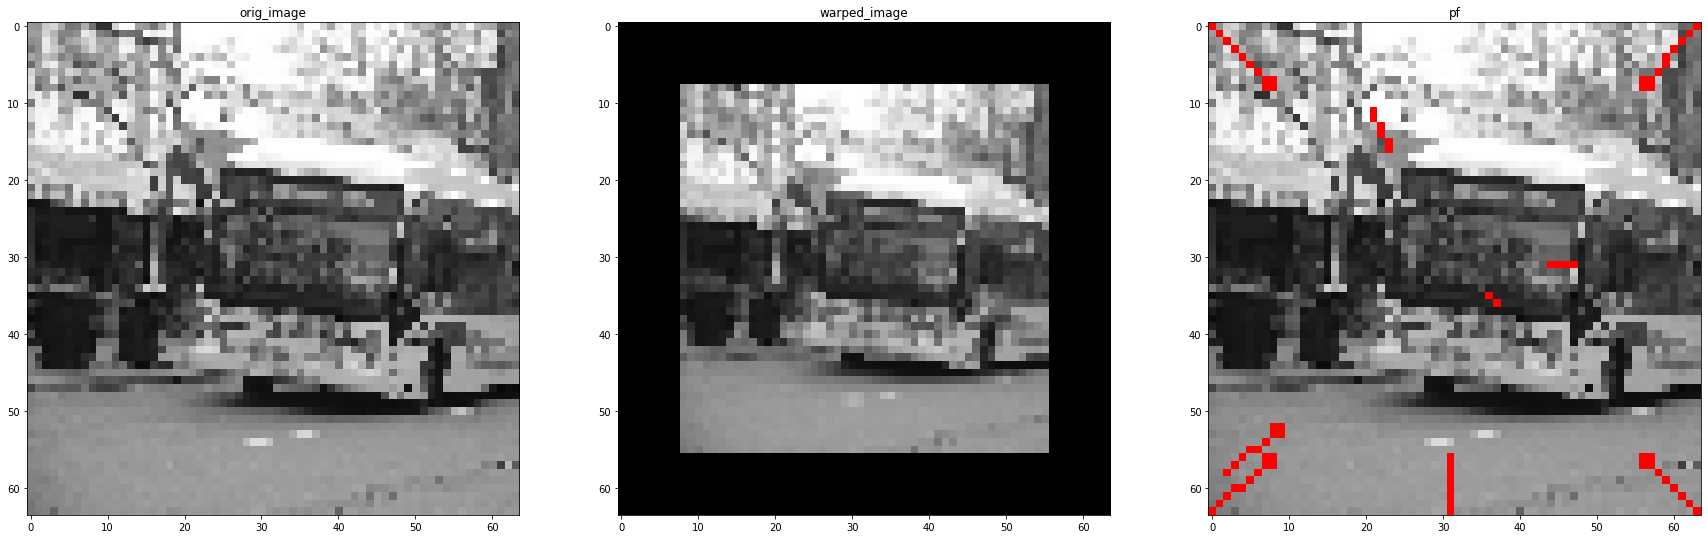

In [8]:

# Create hand-designed warp
_, corners_np, _, homography_np = prepare_train_sample(delta_np = np.array([[8, 8], [-8, 8], [-8, -8], [8, -8]]),
                                                       visualize=False)

# Create perspective field
pf_gt_np = create_gt_perspective_field(h=image_np.shape[0], w=image_np.shape[1],
                                       homography=homography_np, corners=corners_np.astype(int))

# Visualize perspective field
visualize_perspective_field(pf_gt_np, corners=corners_np.astype(int), image_1=image_np,
                            homography=homography_np)

In [9]:
import torch
from typing import Tuple, Optional

import kornia
from kornia.geometry.epipolar import normalize_points

TupleTensor = Tuple[torch.Tensor, torch.Tensor]


def find_homography_dlt(
        points1: torch.Tensor, points2: torch.Tensor, weights: Optional[torch.Tensor] = None) -> torch.Tensor:
    r"""Computes the homography matrix using the DLT formulation.
    The linear system is solved by using the Weighted Least Squares Solution for the 4 Points algorithm.
    Args:
        points1 (torch.Tensor): A set of points in the first image with a tensor shape :math:`(B, N, 2)`.
        points2 (torch.Tensor): A set of points in the second image with a tensor shape :math:`(B, N, 2)`.
        weights (torch.Tensor, optional): Tensor containing the weights per point correspondence with a shape of
                :math:`(B, N)`. Defaults to all ones.
    Returns:
        torch.Tensor: the computed homography matrix with shape :math:`(B, 3, 3)`.
    """
    assert points1.shape == points2.shape, points1.shape
    assert len(points1.shape) >= 1 and points1.shape[-1] == 2, points1.shape
    assert points1.shape[1] >= 4, points1.shape

    eps: float = 1e-8
    points1_norm, transform1 = normalize_points(points1)
    points2_norm, transform2 = normalize_points(points2)

    x1, y1 = torch.chunk(points1_norm, dim=-1, chunks=2)  # BxNx1
    x2, y2 = torch.chunk(points2_norm, dim=-1, chunks=2)  # BxNx1
    ones, zeros = torch.ones_like(x1), torch.zeros_like(x1)

    # DIAPO 11: https://www.uio.no/studier/emner/matnat/its/nedlagte-emner/UNIK4690/v16/forelesninger/lecture_4_3-estimating-homographies-from-feature-correspondences.pdf  # noqa: E501
    ax = torch.cat([zeros, zeros, zeros, -x1, -y1, -ones, y2 * x1, y2 * y1, y2], dim=-1)
    ay = torch.cat([x1, y1, ones, zeros, zeros, zeros, -x2 * x1, -x2 * y1, -x2], dim=-1)
    A = torch.cat((ax, ay), dim=-1).reshape(ax.shape[0], -1, ax.shape[-1])

    if weights is None:
        # All points are equally important
        A = A.transpose(-2, -1) @ A
    else:
        # We should use provided weights
        assert len(weights.shape) == 2 and weights.shape == points1.shape[:2], weights.shape
        w_diag = torch.diag_embed(weights.unsqueeze(dim=-1).repeat(1, 1, 2).reshape(weights.shape[0], -1))
        A = A.transpose(-2, -1) @ w_diag @ A

    try:
        U, S, V = torch.svd(A)
    except:
        warnings.warn('SVD did not converge', RuntimeWarning)
        return torch.empty((points1_norm.size(0), 3, 3), device=points1.device)

    H = V[..., -1].view(-1, 3, 3)
    H = transform2.inverse() @ (H @ transform1)
    H_norm = H / (H[..., -1:, -1:] + eps)
    return H_norm

# Create field of coordinates (help func training)

In [10]:
def create_coord_field(image_size):
    # Create field of the coordinates
    y_patch_grid, x_patch_grid = np.mgrid[0:image_size, 0:image_size]
    x_patch_grid = x_patch_grid.reshape(-1)
    y_patch_grid = y_patch_grid.reshape(-1)
    coordinate_field = np.stack((x_patch_grid, y_patch_grid), axis=0).transpose(1, 0)
    return coordinate_field

coord_field_np = create_coord_field(image_size=64)
coord_field_torch = torch.from_numpy(np.expand_dims(coord_field_np, axis=0).astype(np.float32))

# Create four points (help func for training)

In [11]:
four_points_np = np.array([[0, 0], [image_np.shape[1], 0],
                           [image_np.shape[1], image_np.shape[0]],
                           [0, image_np.shape[0]]])
four_points_torch = torch.from_numpy(np.expand_dims(four_points_np, axis=0)).float()

# Define sample model

In [12]:
class Model(nn.Module):

    def __init__(self, verbose=False):
        super(Model, self).__init__()
        self.verbose = verbose
        
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=2, out_channels=64, kernel_size=5, padding=2, stride=1, bias=False),
                                    nn.GroupNorm(4, 64),
                                    #nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1, bias=False),
                                    #nn.BatchNorm2d(128),
                                    nn.GroupNorm(4, 128),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, bias=False),
                                    #nn.BatchNorm2d(128),
                                    nn.GroupNorm(4, 128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, bias=False),
                                   # nn.BatchNorm2d(128),
                                    nn.GroupNorm(4, 128),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, bias=False),
                                    #nn.BatchNorm2d(128),
                                    nn.GroupNorm(4, 128),
                                    nn.ReLU())
        self.layer6 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=2, kernel_size=3, padding=1, stride=1, bias=True),
                                   # nn.BatchNorm2d(2),
                                   # nn.ReLU()
                                   )

    def forward(self, x):
        if self.verbose:
            print('Do we have nans in the input: ', torch.any(torch.logical_not(torch.isfinite(x))).item())
        
        out = self.layer1(x)
        
        if self.verbose:
            print('Do we have nans after first conv: ', torch.any(torch.logical_not(torch.isfinite(out))).item())
            for a in self.layer1.named_parameters():
                print('Param name: {} mean value: {} '.format(a[0], torch.mean(a[1]).item()))
        
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        return out

# Define sampling method

In [13]:
def sample(points1, points2, points_per_hypothesis):
    
    ###########################################################################
    # Randomly sample points to be used in homography estimation
    ###########################################################################

    batch_size = 1
    points_per_hypothesis = 1024
    points_no = points1.shape[1]
    
    points_to_sample = batch_size * points_per_hypothesis
    range_to_sample = torch.arange(start=0, end=points_no, dtype=torch.float32, device=points1.device)
    choice = torch.multinomial(range_to_sample, points_to_sample, replacement=True)
    choice = choice.reshape(batch_size, -1, 1).repeat((1, 1, 2))
    
    ###########################################################################
    # Extract points1 and points2
    ###########################################################################

    points1_sampled = torch.gather(points1, dim=1, index=choice)
    points2_sampled = torch.gather(points2, dim=1, index=choice)
    return points1_sampled, points2_sampled

# Training loop

In [39]:
model = Model()
model.train()

lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss()

losses = []
for step in range(2000):
    
    # Prepare ground truth
    image_warped_np, corners_np, delta_gt_np, hom_gt_np = prepare_train_sample()
    
    # Prepare input to the model
    model_input = np.concatenate([image_np, image_warped_np], axis=-1)
    model_input = np.expand_dims(np.transpose(model_input, (2, 0, 1)), axis=0)
    model_input = torch.from_numpy(model_input.astype(np.float32))
    
    # Forward pass
    optimizer.zero_grad()
    pf_hat_torch = model.forward(model_input)
    
    # Prepare data for homography
    pf_hat_torch = pf_hat_torch.reshape(1, 2, -1).permute(0, 2, 1)
    map_field_torch = coord_field_torch + pf_hat_torch


    # Sample 1024 points from the whole image
    points_per_hypothesis = 1024
    coord_field_sampled_torch, map_field_sampled_torch = sample(coord_field_torch,
                                                                map_field_torch,
                                                                points_per_hypothesis)
    
    # Use our function with SVD fail warning
    homography_hat_torch = find_homography_dlt(coord_field_sampled_torch,
                                               map_field_sampled_torch)
    
    # Transform corners
    four_points_transformed_torch = kornia.transform_points(homography_hat_torch,
                                                            four_points_torch)
    
    # Estimate delta hat
    delta_hat_torch = four_points_transformed_torch - four_points_torch
    
    # Loss 
    delta_gt_torch = torch.from_numpy(np.expand_dims(delta_gt_np, axis=0))
    loss = loss_fn(delta_gt_torch, delta_hat_torch)
    # calc gradients
    loss.backward()
    # torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
    losses.append(loss.item())
    
    if step % 100 == 0:
        print('Iteration: {} average loss: {} '.format(step, np.mean(losses[-100:])))

    # Optimize
    optimizer.step()

print('Final loss:', np.mean(losses))

Iteration: 0 average loss: 18.34673309326172 
Iteration: 100 average loss: 18.260979599952698 
Iteration: 200 average loss: 14.016012433767319 
Iteration: 300 average loss: 12.314335981607437 
Iteration: 400 average loss: 9.31613269329071 
Iteration: 500 average loss: 9.847054812312127 
Iteration: 600 average loss: 7.906775412559509 
Iteration: 700 average loss: 7.384429861307144 
Iteration: 800 average loss: 8.529106283187867 
Iteration: 900 average loss: 8.120643473863602 
Iteration: 1000 average loss: 6.547075275182724 
Iteration: 1100 average loss: 6.201080725491047 
Iteration: 1200 average loss: 5.294518446922302 
Iteration: 1300 average loss: 5.953243124485016 
Iteration: 1400 average loss: 6.066898629069328 
Iteration: 1500 average loss: 5.414088212251663 
Iteration: 1600 average loss: 5.3692453932762145 
Iteration: 1700 average loss: 4.822477824687958 
Iteration: 1800 average loss: 5.12364521920681 
Iteration: 1900 average loss: 4.524594626426697 
Final loss: 7.807782231390476


# DSAC implementation

In [24]:
def find_homography_dsac(points1: torch.Tensor,
                         points2: torch.Tensor,
                         weights: Optional[torch.Tensor] = None,
                         hypotheses_no: int = 128,
                         points_per_hypothesis: int = 4,
                         ransac_reproj_threshold: float = 0.1):
    r"""Computes the homography matrix using the DSAC method.
    Args:
        points1 (torch.Tensor): A set of points in the first image with a tensor shape :math:`(B, N, 2)`.
        points2 (torch.Tensor): A set of points in the second image with a tensor shape :math:`(B, N, 2)`.
        weights (torch.Tensor): Tensor containing the weights per point correspondence with a shape of :math:`(B, N)` - it will be used as a probability of being chosen to estimate the homography.
        hypotheses_no (int): number of random hypotheses produced by 'DSAC' method.
        points_per_hypothesis (int): how many point correspondences we sample per each hypothesis produced by 'DSAC' method.
        ransac_reproj_threshold (float): Maximum allowed reprojection error to treat a point pair as an inlier.
    Returns:
        torch.Tensor: the computed homography matrix with shape :math:`(B, hypotheses_no, 3, 3)`.
        torch.Tensor: the computed homography score with shape :math:`(B, hypotheses_no)`.
    """

    b = points1.shape[0]
    n = points_per_hypothesis
    points_no = points1.shape[1]

    ###########################################################################
    # Randomly sample points to be used in homography estimation
    ###########################################################################

    points_to_sample = b * n * hypotheses_no
    range_to_sample = torch.arange(start=0, end=points_no, dtype=torch.float32, device=points1.device)
    choice = torch.multinomial(range_to_sample, points_to_sample, replacement=True)
    choice = choice.reshape(b, -1, 1).repeat((1, 1, 2))

    ###########################################################################
    # Extract points1 and points2
    ###########################################################################

    points1_sampled = torch.gather(points1, dim=1, index=choice)
    points2_sampled = torch.gather(points2, dim=1, index=choice)

    ###########################################################################
    # Find homography using kornia dlt
    ###########################################################################

    points1_sampled = points1_sampled.reshape(b * hypotheses_no, n, 2)
    points2_sampled = points2_sampled.reshape(b * hypotheses_no, n, 2)
    homographies = find_homography_dlt(points1_sampled, points2_sampled)
    homographies = homographies.reshape(b, hypotheses_no, 3, 3)

    ###########################################################################
    # Find score for all homographies
    ###########################################################################

    # Reshape input points
    points1 = points1.reshape(b, 1, points_no, 2).repeat(1, hypotheses_no, 1, 1)        # [B, n, N, 2]
    points1 = points1.reshape(b*hypotheses_no, points_no, 2)                            # [B*n, N, 2]

    points2 = points2.reshape(b, 1, points_no, 2).repeat(1, hypotheses_no, 1, 1)        # [B, n, N, 2]
    points2 = points2.reshape(b * hypotheses_no, points_no, 2)                          # [B*n, N, 2]

    # Reshape homographies
    homographies = homographies.reshape(b*hypotheses_no, 3, 3)                          # [B*n, 3, 3]

    # Transform points
    points1_transformed = kornia.transform_points(homographies, points1)                # [B*n, N, 2]

    # inliers ratio score
    reprojection_error = torch.norm(points1_transformed - points2, p=None, dim=-1)      # [B*n, N]
    scores = torch.mean((reprojection_error < ransac_reproj_threshold).to(torch.float32), axis=-1)   # [B*n]
    scores = scores.reshape(b, hypotheses_no)                                           # [B, n]

    # Softmax of the score
    scores = torch.nn.Softmax(dim=-1)(-scores)                                          # [B, n]

    # Final reshape
    homographies = homographies.reshape(b, hypotheses_no, 3, 3)                         # [B, n, 3, 3]
    return homographies, scores

# Training loop with DSAC

In [40]:
model = Model()
model.train()

lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss(reduction='none')

losses = []
for step in range(2000):
    
    # Prepare ground truth
    image_warped_np, corners_np, delta_gt_np, hom_gt_np = prepare_train_sample()
    
    # Prepare input to the model
    model_input = np.concatenate([image_np, image_warped_np], axis=-1)
    model_input = np.expand_dims(np.transpose(model_input, (2, 0, 1)), axis=0)
    model_input = torch.from_numpy(model_input.astype(np.float32))
    
    # Forward pass
    optimizer.zero_grad()
    pf_hat_torch = model.forward(model_input)
    
    # Prepare data for homography
    pf_hat_torch = pf_hat_torch.reshape(1, 2, -1).permute(0, 2, 1)
    map_field_torch = coord_field_torch + pf_hat_torch
    
    # Use our function with SVD fail warning
    hypotheses_no = 128
    homography_hat_torch, homography_scores_torch = find_homography_dsac(coord_field_torch,
                                                                         map_field_torch,
                                                                         points_per_hypothesis=1024,
                                                                         hypotheses_no=hypotheses_no)
    
    # Prepare shapes
    homography_hat_torch = homography_hat_torch.squeeze(dim=0)
    four_points_torch_dsac = four_points_torch.repeat(hypotheses_no, 1, 1)
    
    # Get four points
    four_points_transformed_torch = kornia.transform_points(homography_hat_torch,
                                                            four_points_torch_dsac)
    
    # Estimate delta hat
    delta_hat_torch = four_points_transformed_torch - four_points_torch
    
    # Loss 
    delta_gt_torch = torch.from_numpy(np.expand_dims(delta_gt_np, axis=0))
    loss = loss_fn(delta_gt_torch, delta_hat_torch)
    loss = torch.mean(torch.mean(loss, dim=-1), dim=-1)
    
    # Apply scores
    homography_scores_torch = homography_scores_torch.squeeze(dim=0)
    loss = torch.sum(loss * homography_scores_torch)

    # calc gradients
    loss.backward()
    # torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
    losses.append(loss.item())
    
    if step % 100 == 0:
        print('Iteration: {} average loss: {} '.format(step, np.mean(losses[-100:])))

    # Optimize
    optimizer.step()
    
print('Final loss:', np.mean(losses))

Iteration: 0 average loss: 22.06002426147461 
Iteration: 100 average loss: 19.377067980766295 
Iteration: 200 average loss: 13.926925504207611 
Iteration: 300 average loss: 10.691887224912643 
Iteration: 400 average loss: 9.459968767166139 
Iteration: 500 average loss: 9.268516945838929 
Iteration: 600 average loss: 7.677213234901428 
Iteration: 700 average loss: 8.508301329016685 
Iteration: 800 average loss: 6.155282452702522 
Iteration: 900 average loss: 6.039953497648239 
Iteration: 1000 average loss: 7.2531034553051 
Iteration: 1100 average loss: 5.324674068689347 
Iteration: 1200 average loss: 5.509592475891114 
Iteration: 1300 average loss: 5.639220787286758 
Iteration: 1400 average loss: 5.290467721819877 
Iteration: 1500 average loss: 5.037564415931701 
Iteration: 1600 average loss: 5.493041468262672 
Iteration: 1700 average loss: 5.289071402549744 
Iteration: 1800 average loss: 5.219612403512001 
Iteration: 1900 average loss: 5.548400332927704 
Final loss: 7.558804003596306
